In [1]:
#@title imports { form-width: "22%" }
!pip install hickle

from string import printable
import numpy as np
import pandas as pd
from csv import QUOTE_NONE
import hickle as hkl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
from torchaudio.datasets import LJSPEECH
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from google.colab import drive
drive.mount('/content/drive')


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.9 MB/s eta 0:00:00
Mounted at /content/drive


# Dataset Preprocessing

In [2]:
ds = LJSPEECH('.', download = True)

100%|██████████| 2.56G/2.56G [00:31<00:00, 88.1MB/s]


In [3]:
ds_metadata = pd.read_csv("LJSpeech-1.1/metadata.csv", sep = "|", quoting = QUOTE_NONE, names = ["WAV Name", "Transcripts", "Normalized Transcripts"])


In [4]:
# some normalized transcripts are NaN due to parsing errors (splitting by '|')

# find NaN values
#nan_norm_trans = ds_metadata.isnull().any(axis = 1)

# split the transcripts by '|' and copy the normalized text (second) into the normalized transcript column
#ds_metadata.loc[nan_norm_trans, 'Normalized Transcripts'] = ds_metadata[nan_norm_trans]['Transcripts'].str.split('|').str[1]

ds_metadata.drop('Transcripts', axis = 1, inplace = True)

In [5]:
ds_metadata['Normalized Transcripts'] = ds_metadata['Normalized Transcripts'].str.lower()

ds_metadata['Normalized Transcripts'] = ds_metadata['Normalized Transcripts'].str.replace(' +',' ', regex = True) \
                                                                                 .replace('ü','u', regex = True)  \
                                                                                 .replace('“','"', regex = True)  \
                                                                                 .replace('”', '"', regex = True) \
                                                                                 .replace('’', '\'', regex = True) \
                                                                                 .replace("i.e.", "i e ") \
                                                                                 .replace(";", "") \
                                                                                 .replace ("  ", " ")




# text = text.replace(" -- ", " ")
# text = text.replace("etc.", "etcetera")
# text = text.replace(". ", " ")
# text = text.replace(",", "")
# text = text.replace("\"", "")

In [6]:
# vocab

vocab = printable
for ch in ['\t', '\n', '\r', '\x0b', '\x0c']:
    vocab = vocab.replace(ch, '')

vocab = vocab[10:]
vocab = vocab.replace('ABCDEFGHIJKLMNOPQRSTUVWXYZ', '')
print(vocab)
print(len(vocab))

abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
59


In [7]:
# char to int encoding

def ch_to_int(transcript):
    try:
        return [vocab.index(ch) for ch in transcript]
    except:
        return 'bad encoding'

ds_metadata['One-Hot Encoding'] = ds_metadata['Normalized Transcripts'].apply(ch_to_int)
ds_metadata = ds_metadata[ds_metadata['One-Hot Encoding'] != 'bad encoding']
ds_metadata = ds_metadata.reset_index()

In [8]:
# .wav to mel-spectrogram

SAMPLE_RATE = 22050
N_FFT = 2048 # (2048 - 1) * 2
FRAME_SIZE = 50 # ms
HOP_SIZE = 12.5 # ms
N_MELS = 80

def wav_to_melspec(root):
    data = []
    w2ms_trans = torchaudio.transforms.MelSpectrogram(SAMPLE_RATE,
                                                      n_fft = N_FFT,
                                                      win_length = FRAME_SIZE * SAMPLE_RATE // 1000,
                                                      hop_length = int(HOP_SIZE * SAMPLE_RATE // 1000),
                                                      f_min = 0,
                                                      f_max = 8000,
                                                      n_mels = N_MELS,
                                                      window_fn = torch.hann_window,
                                                      power = 1.0,
                                                      center = False,
                                                      norm = 'slaney',
                                                      mel_scale = 'slaney')

    for i, file_name in enumerate(ds_metadata['WAV Name']):
        wave, _ = torchaudio.load(root + file_name + ".wav")
        wav2melspec = w2ms_trans(wave)
        wav2melspec = torch.clip(wav2melspec, torch.tensor(0.00001))
        amp2db = torch.log(wav2melspec)
        stop_token = np.zeros(amp2db.shape[-1])
        stop_token[-1] = 1.0
        data.append((
           file_name,
           ds_metadata.loc[i, 'Normalized Transcripts'],
           ds_metadata.loc[i, 'One-Hot Encoding'],
           amp2db.numpy()[0],
           stop_token
        ))

    hkl.dump(data, 'ljspeech.hkl', compression = 'gzip')

wav_to_melspec("./LJSpeech-1.1/wavs/")

# Tacotron 2

In [9]:
EPOCHS = 200
BATCH_SIZE = 64 # 16
VOCAB_SIZE = 59
EMBEDDING_SIZE = 512
NR_MELS = 80
LR = 0.001
EPS = 1e-08 #1e-06
WEIGHT_DECAY = 1e-06
THRESHOLD = 0.5
MAX_DEC_STEPS = 1000
CHKP_PATH = 'taco2_1000_ds_size.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#@title Dataset { form-width: "22%" }
class LJSpeech(Dataset):
    def __init__(self, ds_path):
        self.ds = hkl.load(ds_path)
        self.sz = 12000 + 95 + 500 # train, valid, test
        self.ds = self.ds[:self.sz]

    def __len__(self):
        #return len(self.ds)
        return self.sz

    def __getitem__(self, index):
        transcript = torch.LongTensor(self.ds[index][2])
        melspec = torch.FloatTensor(self.ds[index][3])
        stop_token = torch.FloatTensor(self.ds[index][4])
        return transcript, melspec.transpose(1, 0), stop_token # transponse melspec to pad it in collate

    def min_max(self):
        min, max = 10000, -10000
        for (_, melspec, _, _, _) in train_loader:
            melspec_max = torch.max(melspec)
            if melspec_max > max:
                max = melspec_max

            melspec_min = torch.min(melspec)
            if melspec_min < min:
                min = melspec_min

        print(min, max)

def collate_pad(batch):
    transcripts, melspecs, stop_tokens = zip(*batch)
    mel_lens = torch.LongTensor([mel.shape[0] for mel in melspecs])
    trans_lens = torch.LongTensor([t.shape[0] for t in transcripts])

    transcripts = nn.utils.rnn.pad_sequence(transcripts, batch_first = True)
    melspecs = nn.utils.rnn.pad_sequence(melspecs, batch_first = True)
    stop_tokens = nn.utils.rnn.pad_sequence(stop_tokens, batch_first = True)
    for i, elem in enumerate(stop_tokens):
        elem[mel_lens[i] - 1:] = 1.0
    return transcripts, melspecs.permute(0, 2, 1), stop_tokens, mel_lens, trans_lens

In [11]:
#@title Encoder { form-width: "22%" }
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()

        self.embedding_size = embedding_size

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_size, embedding_size, 5, padding = 2, bias = True),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(embedding_size, embedding_size, 5, padding = 2, bias = True),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(embedding_size, embedding_size, 5, padding = 2, bias = True),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(),
            nn.Dropout()
        )

        for layer in self.conv:
            if isinstance(layer, nn.Conv1d):
                torch.nn.init.xavier_uniform_(layer.weight, gain = torch.nn.init.calculate_gain('relu'))

        self.bi_lstm = nn.LSTM(embedding_size, embedding_size // 2,
                               batch_first = True, bidirectional = True)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.embed(x)
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x, _ = self.bi_lstm(x)
        return x

In [12]:
#@title Attention { form-width: "22%" }
class AlignNN(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        '''
        Calculates the alignment of the arguments, representing the importance of each encoder output.
        Args:
            enc_hidden_size: output size of encoder at step j
            dec_hidden_size: size of previous hidden state of the decoder
        '''
        super().__init__()
        self.ll_dec_prev_hidden = nn.Linear(dec_hidden_size, 128)
        self.ll_enc_hidden = nn.Linear(enc_hidden_size, 128)
        self.ll_prev_step_att = nn.Linear(32, 128)
        self.ll_out = nn.Linear(128, 1)

        self.proj1 = None # saves encoder hidden LL output


    def forward(self, dec_prev_hidden, prev_step_att):
        proj2 = self.ll_dec_prev_hidden(dec_prev_hidden) # (BATCH_SIZE, seq_len = 1, hidden_size = 128)
        proj3 = self.ll_prev_step_att(prev_step_att.transpose(2, 1))
        return self.ll_out(torch.tanh(self.proj1 + proj2 + proj3)).squeeze(2)

class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        '''
        Calculates attention (https://arxiv.org/abs/1409.0473)
        Args:
            enc_hidden_size: output size of encoder at step j
            dec_hidden_size: size of previous hidden state of the decoder
        '''
        super().__init__()
        self.location_att = nn.Conv1d(2, 32, 31, padding = 15)
        self.align_nn = AlignNN(enc_hidden_size, dec_hidden_size)
        self.mask = None


    def forward(self, enc_out, dec_prev_h, prev_step_att):
        # location features
        location_features = self.location_att(prev_step_att)

        # calculate the attention weights
        att_weights = self.align_nn(dec_prev_h, location_features) # (BATCH_SIZE, seq_len)

        if self.mask is not None:
            att_weights.data.masked_fill_(self.mask, -float('inf'))

        att_weights = torch.softmax(att_weights, dim = 1)
        return att_weights, torch.bmm(att_weights.unsqueeze(1), enc_out).squeeze(1)

In [14]:
#@title Decoder { form-width: "22%" }
# Pieces of code adapted from: https://github.com/NVIDIA/tacotron2
class Decoder(nn.Module):
    def __init__(self, melspec_frame_shape):
        super().__init__()
        self.pre_net = nn.Sequential(
            nn.Linear(melspec_frame_shape, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout()
        )

        self.lstm_l1 = nn.LSTM(EMBEDDING_SIZE + 256, 1024, 1, batch_first = True)
        self.att_nn = None # the attention network
        self.lstm_l2 = nn.LSTM(EMBEDDING_SIZE + 1024, 1024, 1, batch_first = True)

        self.linear = nn.Linear(EMBEDDING_SIZE + 1024, 80)
        self.stop_linear = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE + 1024, 1),
        )
        self.post_net = nn.Sequential(
            nn.Conv1d(NR_MELS, 512, 5, padding = 2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(),
            nn.Conv1d(512, 512, 5, padding = 2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(),
            nn.Conv1d(512, 512, 5, padding = 2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(),
            nn.Conv1d(512, 512, 5, padding = 2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(),
            nn.Conv1d(512, NR_MELS, 5, padding = 2),
            nn.BatchNorm1d(NR_MELS),
            nn.Dropout()
        )


    def get_mask_from_lengths(self, lengths):
        max_len = torch.max(lengths).item()
        ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
        mask = (ids < lengths.unsqueeze(1)).bool()
        return mask


    def init_states(self, enc_out, trans_lens, batch_size, seq_len, train_mode = True):
        self.h_n1 = torch.zeros((1, batch_size, 1024), requires_grad = train_mode).to(DEVICE) # (nr_layers, BATCH_SIZE, hidden_size)
        self.c_n1 = torch.zeros((1, batch_size, 1024), requires_grad = train_mode).to(DEVICE) # (nr_layers, BATCH_SIZE, hidden_size)
        self.h_n2 = torch.zeros((1, batch_size, 1024), requires_grad = train_mode).to(DEVICE) # (nr_layers, BATCH_SIZE, hidden_size)
        self.c_n2 = torch.zeros((1, batch_size, 1024), requires_grad = train_mode).to(DEVICE) # (nr_layers, BATCH_SIZE, hidden_size)

        self.prev_step_att = torch.zeros((batch_size, seq_len), requires_grad = train_mode).to(DEVICE)
        self.prev_steps_att = torch.zeros((batch_size, seq_len), requires_grad = train_mode).to(DEVICE)

        self.context_vec = torch.zeros((batch_size, EMBEDDING_SIZE), requires_grad = train_mode).to(DEVICE)

        self.enc_out = enc_out
        self.att_nn.align_nn.proj1 = self.att_nn.align_nn.ll_enc_hidden(enc_out)
        if trans_lens != None:
            self.att_nn.mask = ~self.get_mask_from_lengths(trans_lens)

    def forward(self, prev_frame):
        '''
        Args:
            context_vector: the attention context vector for current step (BATCH_SIZE, EMBEDDING_SIZE)
            prev_frame: previous step output (frame), using teacher forcing for training (NR_MELS, BATCH_SIZE)
            h_x: tuple containing last step's hidden and cell states
                 h_n shape: (num_layers = 2, BATCH_SIZE, hidden_size = 1024)
                 c_n shape: (num_layers = 2, BATCH_SIZE, hidden_size = 1024)
        '''
        prev_frame = prev_frame.transpose(1, 0)

        x = torch.concat([self.context_vec, prev_frame], dim = -1)
        x = x.unsqueeze(1) # LSTM input shape: (batch_size, seq_len = 1, input_len)
        _, (self.h_n1, self.c_n1) = self.lstm_l1(x, (self.h_n1, self.c_n1))
        self.h_n1 = nn.functional.dropout(self.h_n1, 0.1, True)

        att = torch.cat((self.prev_step_att.unsqueeze(1), self.prev_steps_att.unsqueeze(1)), dim = 1)
        self.prev_step_att, self.context_vec = self.att_nn(self.enc_out, self.h_n1.squeeze(0).unsqueeze(1), att)
        self.prev_steps_att += self.prev_step_att

        x = torch.concat([self.h_n1.squeeze(0), self.context_vec], dim = -1).unsqueeze(1)
        _, (self.h_n2, self.c_n2) = self.lstm_l2(x, (self.h_n2, self.c_n2))
        self.h_n2 = nn.functional.dropout(self.h_n2, 0.1, True)

        x = torch.concat([self.context_vec, self.h_n2.squeeze(0)], dim = 1)
        x_out = self.linear(x)
        x_stop = self.stop_linear(x)
        return  x_out, x_stop


In [1]:
#@title Tacotron2 { form-width: "22%" }
class Tacotron2(nn.Module):
    def __init__(self, enc_bi_lstm_size = 256, dec_lstm_size = 1024, train_mode = True):
        super().__init__()

        self.train_mode = True
        self.prev_train_loss = float('inf')
        self.prev_valid_loss = float('inf')

        self.enc = Encoder(VOCAB_SIZE, EMBEDDING_SIZE)
        self.dec = Decoder(NR_MELS)
        self.dec.att_nn = Attention(enc_bi_lstm_size * 2, dec_lstm_size)


        self.optimizer = torch.optim.Adam(self.parameters(), lr = LR, eps = EPS, weight_decay = WEIGHT_DECAY)


    def init_states(self, batch_size, seq_len):
        self.frame = torch.zeros((batch_size, NR_MELS), requires_grad = self.train_mode).to(DEVICE)
        self.h_n = torch.zeros((2, batch_size, 1024), requires_grad = self.train_mode).to(DEVICE)
        self.c_n = torch.zeros((2, batch_size, 1024), requires_grad = self.train_mode).to(DEVICE)

        self.prev_step_att = torch.zeros((batch_size, seq_len), requires_grad = self.train_mode).to(DEVICE)
        self.prev_steps_att = torch.zeros((batch_size, seq_len), requires_grad = self.train_mode).to(DEVICE)


    def mask_outputs(self, melspecs, res_melspecs, stop_tokens, mel_lens):
        mel_mask = torch.zeros(melspecs.shape, dtype = torch.bool).to(DEVICE)
        stop_mask = torch.zeros(stop_tokens.shape, dtype = torch.bool).to(DEVICE)
        for i, len in enumerate(mel_lens):
            mel_mask[i, :, len:] = True
            stop_mask[i, len:] = True

        melspecs.data.masked_fill_(mel_mask, 0.0)
        res_melspecs.data.masked_fill_(mel_mask, 0.0)
        stop_tokens.data.masked_fill_(stop_mask, 1e3)

        return melspecs, res_melspecs, stop_tokens

    def _forward(self, transcript, trans_lens, melspec, stop_tokens, mel_lens):

        loss = 0.0
        x_outs, x_stops = [], []

        enc_out = self.enc(transcript)
        self.init_states(transcript.shape[0], transcript.shape[-1])
        self.dec.init_states(enc_out, trans_lens, transcript.shape[0], transcript.shape[-1], self.train_mode)
        melspec = self.dec.pre_net(melspec.permute(0, 2, 1))
        self.frame = self.dec.pre_net(self.frame).transpose(1, 0) # initial frame
        melspec = melspec.permute(1, 2, 0) # permute in order to traverse the frames
        for i, crt_frame in enumerate(melspec):
            x_out, x_stop = self.dec(self.frame)
            x_outs.append(x_out)
            x_stops.append(x_stop)

            self.frame = crt_frame

        x_out = torch.stack(x_outs, dim = 2)
        out = x_out + self.dec.post_net(x_out)
        x_stops = torch.cat(x_stops, dim = 1)
        return x_out, out, x_stops

    def _inference(self, transcript):
        self.eval()
        with torch.no_grad():
            enc_out = self.enc(transcript)
            self.init_states(transcript.shape[0], transcript.shape[-1])
            self.dec.init_states(enc_out, None, transcript.shape[0], transcript.shape[-1])
            x_stop = torch.FloatTensor([-1.0])
            crt_steps = 0
            melspec = []
            frame = torch.zeros((transcript.shape[0], NR_MELS)).to(DEVICE)
            while torch.sigmoid(x_stop).item() < THRESHOLD and crt_steps < MAX_DEC_STEPS:
                frame = self.dec.pre_net(frame).transpose(1, 0)
                x_out, x_stop = self.dec(frame)
                melspec.append(x_out)
                frame = x_out
                crt_steps += 1
            melspec = torch.stack(melspec, dim = 2)
            melspec = melspec + self.dec.post_net(melspec)
        return melspec.cpu().numpy()

    def forward(self, transcript, trans_lens = None, melspec = None, stop_tokens = None, mel_lens = None):
        if self.train_mode:
            return self._forward(transcript, trans_lens, melspec, stop_tokens, mel_lens)
        else:
            return self._inference(transcript)

    def criterion(self, y_pred, y):
        # taken from: https://github.com/NVIDIA/tacotron2
        x_out, out, x_stop = y_pred[0], y_pred[1], y_pred[2]
        melspec, stop_tokens = y
        loss = nn.MSELoss()(x_out, melspec) + \
               nn.MSELoss()(out, melspec) + \
               nn.BCEWithLogitsLoss()(x_stop, stop_tokens)
        return loss

    def get_mask_from_lengths(self, lengths):
        # taken from: https://github.com/NVIDIA/tacotron2
        max_len = torch.max(lengths).item()
        ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
        mask = (ids < lengths.unsqueeze(1)).bool()
        return mask

    def parse_outputs(self, melspecs, res_melspecs, stop_tokens, mel_lens):
        # taken from: https://github.com/NVIDIA/tacotron2
        if mel_lens is not None:
            mask = ~self.get_mask_from_lengths(mel_lens)
            mask = mask.expand(NR_MELS, mask.size(0), mask.size(1))
            mask = mask.permute(1, 0, 2)

            melspecs.data.masked_fill_(mask, 0.0)
            res_melspecs.data.masked_fill_(mask, 0.0)
            stop_tokens.data.masked_fill_(mask[:, 0, :], 1e3)  #1e3 # gate energies
        return (melspecs, res_melspecs, stop_tokens)

    def fit(self, train_loader, valid_loader):
        train_losses, valid_losses = [], []
        self.train_mode = True
        self.train()
        for e in range(EPOCHS):
            total_loss = 0
            for (trans, melspec, stop_tokens, mel_lens, trans_lens) in train_loader:
                trans = trans.to(DEVICE)
                melspec = melspec.to(DEVICE)
                stop_tokens = stop_tokens.to(DEVICE)
                mel_lens = mel_lens.to(DEVICE)
                trans_lens = trans_lens.to(DEVICE)

                out = self(trans, trans_lens, melspec, stop_tokens)
                out = self.parse_outputs(out[0], out[1], out[2], mel_lens)
                loss = self.criterion(out, (melspec, stop_tokens))
                total_loss += loss.item()

                self.zero_grad(set_to_none = True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                self.optimizer.step()
            total_loss /= len(train_loader)
            train_losses.append(total_loss)
            print("#{} TRAIN LOSS: {:.4f}".format(e, total_loss), end = "\n")
            self.save(total_loss, valid_loss = None)
            plt.plot(train_losses)

    def validate(self, loader):
        self.eval()
        with torch.no_grad():
            total_loss = 0.0
            for (trans, melspec, stop_tokens, mel_lens) in loader:
                trans = trans.to(DEVICE)
                melspec = melspec.to(DEVICE)
                stop_tokens = stop_tokens.to(DEVICE)
                out = self(trans, melspec, stop_tokens, mel_lens)
                loss = self.criterion(out, (melspec, stop_tokens))
                total_loss += loss.item()
            total_loss /= len(loader)
        self.train()
        print("EVAL LOSS: {:.4f}".format(total_loss))
        return total_loss

    def save(self, train_loss, valid_loss = None):
        torch.save({
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, CHKP_PATH)

    def load(self):
        checkpoint = torch.load(CHKP_PATH, map_location=torch.device(DEVICE))
        self.prev_train_loss = checkpoint['train_loss']
        self.prev_valid_loss = checkpoint['valid_loss']
        print("Current checkpoint train loss: {:.4f}".format(checkpoint['train_loss']))
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.load_state_dict(checkpoint['model_state_dict'])


NameError: name 'nn' is not defined

Dataset size: 12595
Transcript shape: torch.Size([151])
Melspectrogram shape: torch.Size([767, 80])
Stop token shape: torch.Size([767])


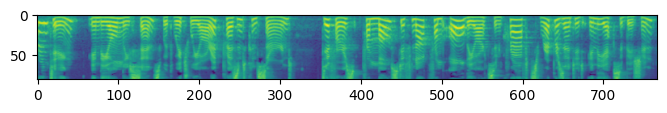

In [16]:
ds = LJSpeech("ljspeech.hkl")


print("Dataset size:", len(ds))
print("Transcript shape:", ds[0][0].shape)
print("Melspectrogram shape:", ds[0][1].shape)
print("Stop token shape:", ds[0][2].shape)

plt.figure(figsize = (8, 6), dpi = 100)
p = plt.imshow(ds[0][1][:, :].transpose(1, 0))

train_ds, valid_ds, test_ds = torch.utils.data.random_split(ds, [12000, 95, 500], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_pad)
valid_loader = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_pad)

sample = next(iter(train_loader))

In [23]:
taco = Tacotron2().to(DEVICE)

In [24]:
taco.load()

Current checkpoint train loss: 0.7567


<ipython-input-14-05ce5aef4c1c>:48: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))


#0 TRAIN LOSS: 3.3527
#1 TRAIN LOSS: 1.5326
#2 TRAIN LOSS: 1.2418
#3 TRAIN LOSS: 1.0816
#4 TRAIN LOSS: 0.9393
#5 TRAIN LOSS: 0.8515
#6 TRAIN LOSS: 0.7955
#7 TRAIN LOSS: 0.7567


KeyboardInterrupt: 

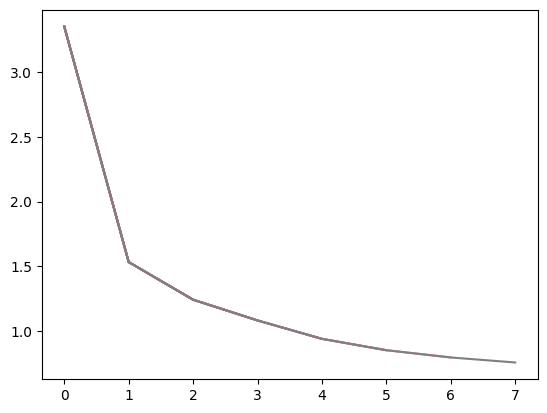

In [18]:
taco.fit(train_loader, valid_loader)

# Generating audio files using HiFi-GAN
taken from: https://github.com/jik876/hifi-gan

In [25]:
import IPython.display as ipd

In [26]:
ipd.Audio('LJSpeech-1.1/wavs/LJ001-0001.wav')

In [28]:
import os

# torch.Size([1, 80, 831])
test_loader = DataLoader(train_ds, batch_size = 1, shuffle = True, collate_fn = collate_pad)
sample = next(iter(test_loader))
sample = next(iter(test_loader))
transcript = sample[0].to(DEVICE)
orig_melspec = sample[1]
taco.eval()
taco.train_mode = False
melspec = taco(transcript) # the input is the transcript
print(orig_melspec.shape)
print(melspec.shape)

os.makedirs("test_mel_files", exist_ok=True)

np.save("test_mel_files/original.npy", orig_melspec[0].numpy()) # for example
np.save("test_mel_files/taco2_output.npy", melspec[0])

torch.Size([1, 80, 632])
(1, 80, 1000)


In [33]:
!python inference_e2e.py --checkpoint_file generator_v3

Initializing Inference Process..
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Loading 'generator_v3'
Complete.
Removing weight norm...
generated_files_from_mel/original_generated_e2e.wav
generated_files_from_mel/taco2_output_generated_e2e.wav


In [34]:
ipd.Audio('generated_files_from_mel/original_generated_e2e.wav')

In [35]:
ipd.Audio('generated_files_from_mel/taco2_output_generated_e2e.wav')